# Lab 4
James Lu, Soroush Famili, Nithanth Ram

# Problem 1 – Warm up. Grid Search CV.

1. Run this simple example from scikit learn, and understand what each command is doing:
https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html


# Parameter estimation using grid search with cross-validation


This examples shows how a classifier is optimized by cross-validation,
which is done using the :class:`sklearn.model_selection.GridSearchCV` object
on a development set that comprises only half of the available labeled data.

The performance of the selected hyper-parameters and trained model is
then measured on a dedicated evaluation set that was not used during
the model selection step.

More details on tools available for model selection can be found in the
sections on `cross_validation` and `grid_search`.




In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn import linear_model
%matplotlib inline

print(__doc__)

Automatically created module for IPython interactive environment


In [17]:
# Loading the Digits dataset
digits = datasets.load_digits()

# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
y = digits.target

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']


In [3]:
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    print("Constructor finished")
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Note the problem is too easy: the hyperparameter plateau is too flat and the
# output model is the same for precision and recall with ties in quality.

# Tuning hyper-parameters for precision

Constructor finished
Best parameters set found on development set:

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.986 (+/-0.016) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.959 (+/-0.029) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.982 (+/-0.026) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.982 (+/-0.025) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.982 (+/-0.025) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.975 (+/-0.014) for {'C': 1, 'kernel': 'linear'}
0.975 (+/-0.014) for {'C': 10, 'kernel': 'linear'}
0.975 (+/-0.014) for {'C': 100, 'kernel': 'linear'}
0.975 (+/-0.014) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The 

# Problem 2 – Lasso, Forward Selection and Cross Validation.
Use the data generation used in the Lecture 7 notebook, where we first introduced Lasso, to generate
data.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# generate some sparse data to play with
np.random.seed(7)

n_samples, n_features = 100, 200

train_samples = int(n_samples/4)
test_samples = n_samples - train_samples

X = np.random.randn(n_samples, n_features)

k = 5
# beta generated with k nonzeros
#coef = 10 * np.random.randn(n_features)
coef = 10 * np.ones(n_features)
inds = np.arange(n_features)
np.random.shuffle(inds)
coef[inds[k:]] = 0  # sparsify coef

non_zero_indices = []

for i in range(len(coef)):
    if coef[i] != 0:
        non_zero_indices.append(i)
        
print(non_zero_indices)
y = np.dot(X, coef)

# add noise
y += 0.01 * np.random.normal((n_samples,))

# Split data in train set and test set
n_samples = X.shape[0]
X_train, y_train = X[:train_samples], y[:train_samples]
X_test, y_test = X[train_samples:], y[train_samples:]


[15, 18, 34, 51, 78]


<b>i. Manually implement forward selection. Report the order in which you add features.</b>

In [5]:
feature_order = []
test_errors = {}
min_test_errors = []

alpha = .5

for i in range(0, n_features):
    
    X_fs = np.ones((train_samples, 1)) # Add bias
    X_fs_test = np.ones((test_samples, 1))
    
    for feature in feature_order:
        
        train_feature = np.reshape(X_train[:, feature], (train_samples,1)) # Adding the features we previously selected
        test_feature = np.reshape(X_test[:, feature], (test_samples,1))
        
        X_fs = np.hstack((X_fs, train_feature))
        X_fs_test = np.hstack((X_fs_test, test_feature))
    
    for k in range(0, n_features):
        
        if k not in feature_order: # If we haven't picked this feature yet
            
            train_feature = np.reshape(X_train[:, k], (train_samples,1))
            test_feature = np.reshape(X_test[:, k], (test_samples,1))

            X_fs_feature = np.hstack((X_fs, train_feature))
            X_fs_feature_test = np.hstack((X_fs_test, test_feature))
            
            inverse = np.linalg.inv(np.dot(X_fs_feature.T, X_fs_feature) + alpha*np.eye(X_fs_feature.shape[1]))
            
            beta_hat = np.dot(inverse, np.dot(X_fs_feature.T, np.reshape(y_train, (train_samples,1))))
            
            error_vector = np.reshape(y_test, (test_samples,1)) - np.dot(X_fs_feature_test, beta_hat)
            
            test_errors[k] = np.linalg.norm(error_vector, ord=2)**2
            
    
    best_current_feature = min(test_errors, key=test_errors.get) 
    feature_order.append(best_current_feature)
    min_test_errors.append(test_errors[best_current_feature]) # Save for plotting in part 2
    test_errors = {}        

In [6]:
print("Top " + str(n_features) + " features: ")
print(feature_order)

Top 200 features: 
[18, 51, 78, 137, 15, 34, 57, 6, 151, 199, 181, 138, 136, 154, 31, 105, 60, 17, 108, 59, 94, 95, 141, 89, 194, 189, 120, 119, 88, 150, 139, 162, 121, 14, 101, 100, 169, 64, 41, 180, 110, 43, 170, 2, 69, 32, 160, 45, 44, 5, 92, 144, 28, 192, 58, 165, 70, 68, 133, 83, 129, 7, 16, 184, 12, 97, 135, 196, 159, 33, 99, 166, 76, 131, 188, 193, 90, 134, 112, 74, 127, 52, 40, 25, 10, 149, 1, 26, 187, 77, 91, 158, 85, 130, 117, 148, 63, 55, 168, 84, 152, 11, 167, 30, 122, 21, 182, 87, 176, 86, 62, 103, 140, 107, 27, 39, 163, 35, 54, 179, 128, 53, 173, 186, 115, 175, 4, 61, 37, 23, 36, 116, 3, 157, 56, 0, 111, 67, 174, 47, 102, 49, 114, 143, 104, 156, 73, 29, 146, 118, 22, 8, 195, 191, 71, 183, 124, 38, 20, 79, 82, 145, 66, 106, 190, 9, 109, 81, 147, 19, 113, 13, 171, 24, 50, 48, 198, 42, 80, 75, 98, 123, 132, 93, 96, 161, 172, 197, 125, 153, 65, 126, 177, 155, 46, 72, 164, 142, 178, 185]


<b>ii. Plot test error as a function of the size of the support. Can you use this to recover the true support?</b>

Yes - find the beta-hats that correspond to the minimum test error

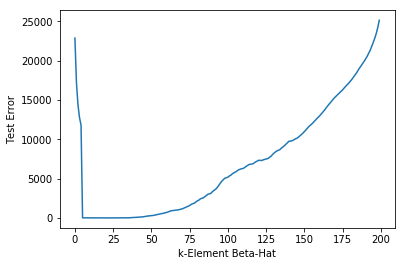

In [7]:
plt.plot(min_test_errors)
plt.xlabel("k-Element Beta-Hat")
plt.ylabel("Test Error")
plt.show()

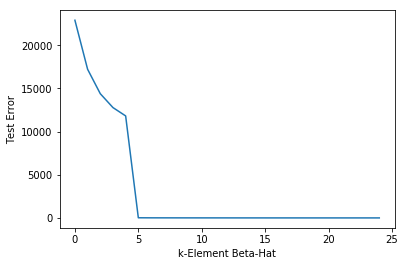

In [8]:
plt.plot(min_test_errors[:25])
plt.xlabel("k-Element Beta-Hat")
plt.ylabel("Test Error")
plt.show()

In [9]:
min_error = min(min_test_errors)
min_error_index = np.argmin(min_test_errors)
print(min_error)
print(min_error_index)

21.67616387727375
21


<b>iii. Use Lasso with a manually implemented Cross validation using the metric of your choice. What is the value of the hyperparameter? (Manually implemented means that you can either do it entirely on your own, or you can use GridSearchCV, but I’m asking you not to use LassoCV, which you will use in the next problem).</b>


In [10]:
def Lasso(X_train, y_train, X_test, y_test, alpha):
    
    clf = linear_model.Lasso(alpha=alpha, max_iter=10000)
    clf.fit(X_train, y_train)
    
    beta_hat = clf.coef_
    
    error_vector = y_test - np.dot(X_test, beta_hat)
            
    test_error = np.linalg.norm(error_vector, ord=2)**2
    
    return test_error

In [11]:
def Lasso_CV(folds=10):
    splits = []
    temp = 0

    d = int(n_samples/folds)
    n = n_samples - d

    for i in range(0, folds + 1):
        splits.append(temp)
        temp += d

    alphas = [.0001, .001, .005, .01, .05, .1, .5]

    average_errors = []

    for alpha in alphas:

        error = 0

        for index in range(0, len(splits) - 1):

            if index == 0:
                X_test_CV = np.reshape(X[splits[index]:splits[index + 1], :], (d, n_features))
                X_train_CV = np.reshape(X[splits[index + 1]:, :], (n, n_features))

                y_test_CV = np.reshape(y[splits[index]:splits[index + 1]], (d,1))
                y_train_CV = np.reshape(y[splits[index + 1]:], (n,1))

            elif index == len(splits) - 2:
                X_test_CV = np.reshape(X[splits[index]:, :], (d, n_features))
                X_train_CV = np.reshape(X[:splits[index], :], (n, n_features))

                y_test_CV = np.reshape(y[splits[index]:], (d,1))
                y_train_CV = np.reshape(y[:splits[index]], (n,1))

            else:

                X_1 = X[0:splits[index], :]
                X_test_CV = np.reshape(X[splits[index]:splits[index + 1], :], (d, n_features))
                X_2 = X[splits[index + 1]:, :]

                X_train_CV = np.reshape(np.concatenate((X_1, X_2)), (n, n_features))

                y_1 = y[0:splits[index]]
                y_test_CV = y[splits[index]:splits[index + 1]]
                y_2 = y[splits[index + 1]:]

                y_train_CV = np.reshape(np.concatenate((y_1, y_2)), (n, 1))


            err = Lasso(X_train_CV, y_train_CV, X_test_CV, y_test_CV, alpha)
            error += err

        error = error/folds
        average_errors.append(error)

    alpha = average_errors.index(min(average_errors))
    print("Best Hyperparameter: " + str(alphas[alpha]))

    plt.plot(alphas, average_errors)
    plt.xscale("log")
    plt.xlabel("LASSO Hyperparameter Value")
    plt.ylabel(str(folds) + "-Fold CV Average Error")
    plt.show()


Best Hyperparameter: 0.5


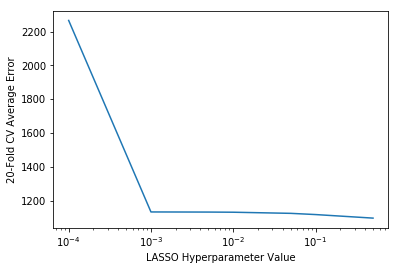

In [12]:
Lasso_CV(folds=20)

<b>iv. Change the number of folds in your CV and repeat the previous step. How does the optimal value of the hyperparameter change? Try to explain any trends that you find.</b>

Best Hyperparameter: 0.5


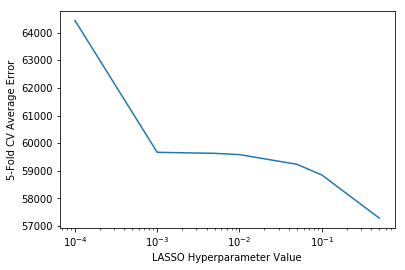

Best Hyperparameter: 0.5


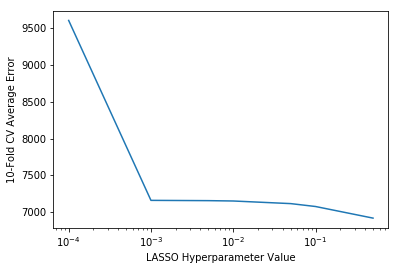

Best Hyperparameter: 0.5


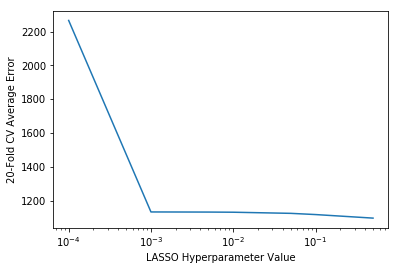

Best Hyperparameter: 0.1


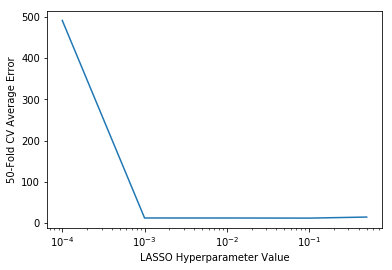

Best Hyperparameter: 0.05


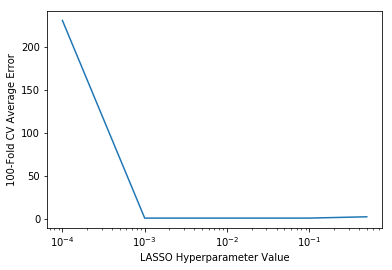

In [13]:
folds = [5,10,20,50,100]

for fold in folds:
    Lasso_CV(folds=fold)


As the number of folds increases, the optimal hyperparameter decreases. Because the model is training on more of the samples as the fold number increases, the model becomes more accurate before the Lasso penalty, leading to a lower necessity for the penalty, thus elading to a smaller hyperparameter. 

<b>v. Read about and use LassoCV from sklearn.linear model. How does this compare with what
you did in the previous step? If they agree, then explain why they agree, and if they disagree
explain why. This will require you to make sure you understand what LassoCV is doing</b>

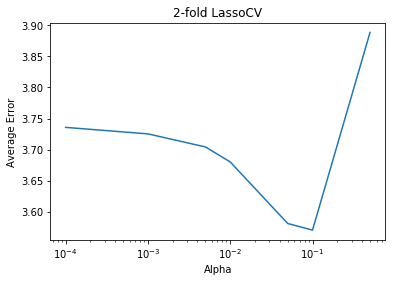

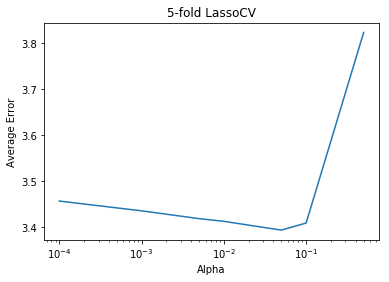

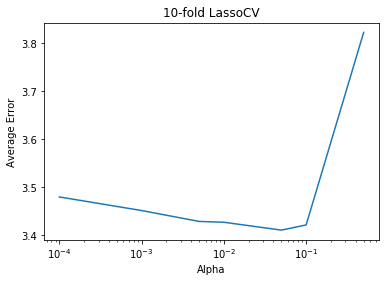

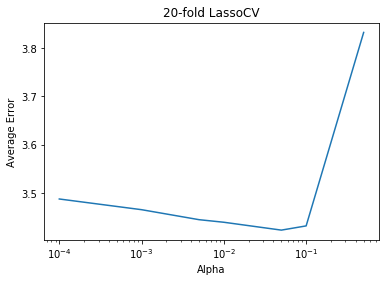

In [18]:
from sklearn.linear_model import LassoCV

folds = [2,5,10,20]  # cant have more folds than samples

for fold in folds:
    lasso = LassoCV(cv=fold, alphas=[.0001, .001, .005, .01, .05, .1, .5]).fit(X_train, y_train)
    plt.xscale("log")
    plt.title(str(fold) + "-fold LassoCV")
    plt.xlabel("Alpha")
    plt.ylabel("Average Error")
    means = [mse.mean() for mse in lasso.mse_path_]
    plt.plot(lasso.alphas_, means)
    plt.show()
    

# Problem 3 – Higher vs Lower K in K-Fold CV

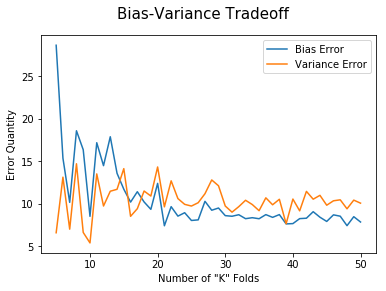

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV
import pandas as pd
from pandas import DataFrame, Series
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

bias_list = []

variance_list = []

alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10, 30, 50]

for x in range(5,51,1):

    # generate some sparse data to play with

    np.random.seed(7)



    n_samples, n_features = x, 10

    X = np.random.randn(n_samples, n_features)



    k = 5

    # beta generated with k nonzeros

    #coef = 10 * np.random.randn(n_features)

    coef = 10 * np.ones(n_features)

    inds = np.arange(n_features)

    np.random.shuffle(inds)

    coef[inds[k:]] = 0  # sparsify coef

    y = np.dot(X, coef)



    # add noise

    y += 0.01 * np.random.normal((n_samples,))

    



    # Split data in train set and test set

    n_samples = X.shape[0]

#     X_train, y_train = X[:25], y[:25]

#     X_test, y_test = X[25:], y[25:]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

    

    #ridge regression with alpha value of 0.1

    ridge_cv = RidgeCV(alphas = alphas, normalize = True, cv = None, store_cv_values = True)

    pred_ridge_cv_error = ridge_cv.fit(X_train, y_train).cv_values_

    bias = np.mean(np.sqrt(pred_ridge_cv_error)) #model's bias is the mean of the error estimation from k-fold cross validation

    variance = np.std(np.sqrt(pred_ridge_cv_error)) #model's variance  is the stdev of the error estimation from k-fold cross validation

    bias_list.append((x, bias)) #append tuple of K folds and bias error

    variance_list.append((x, variance)) #append tuple of K folds and variance error



# print(list(bias_list))

# print(list(variance_list))



fig = plt.figure()

plt.plot((*zip(*bias_list)), label = 'Bias Error')

plt.plot((*zip(*variance_list)), label='Variance Error')

fig.suptitle('Bias-Variance Tradeoff', fontsize=15)

plt.xlabel('Number of "K" Folds', fontsize=10)

plt.ylabel('Error Quantity', fontsize=10)

plt.legend()

plt.show()

In the figure above. The Bias-Variance Tradeoff is investigated and displayed. The experiment involved running Ridge Regression on a version of randomly generated sample data taken from class lecture. In the script, a K-fold cross validation of a Ridge Regression was run iteratively for increasing values of K (the number of times the data set is partitioned: k-1 training sets, 1 test set). Multiple alpha values were used in the cross validation for a more fully-functioning cross validation, and each iteration of the experiment outputted a bias value and variance value. The trend observed clearly outlines the Bias-Variance tradeoff. As the number of folds in the cross validation increases, the bias of the data decreases, while the variance increases. This holds consistent with generic intuition of the K-folds cross validation process. As the set gets trained with more iterations and partitioned data sets, the bias will decrease because of stronger accuracy between the expected prediction of the model and the correct value it is trying to predict. However, inversely, the variance of the model will increase because with multiple iterations of training due to multiple partitioned training sets, the predictions for a given point will vary between different realizations of the model. Too high of a K-value will lead to overfitting of the model. That is why it is important to select an optimal K-value that balances the bias error and the variance error of the model.